In [1]:
import torch
import random
import glob
import cv2
from PIL import Image, ImageDraw, ImageFont
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
import torchvision
import torchvision.datasets as datasets

# Create own Dataset with digital digits

In [2]:
class DigitalDigits(torch.utils.data.Dataset):
    def __init__(self):
        self.fonts = glob.glob("fonts/*.ttf")
        self.fonts_dict = {}
        self.digits_ = [None] * 60000
        self.generate_all()

    def __getitem__(self, index):
        return self.digits_[index]
    
    def __len__(self):
        return 60000

    def generate_all(self):
        for p in range(60000):
            self.digits_[p] = self.generate_digit()

    def generate_digit(self):
        digit = random.randint(0, 9)
        data = self.generate_pil(digit)
        return data, digit

    def generate_pil(self, digit: int):
        text = str(digit)
        area_size = 2*28
        img = Image.new("L", (area_size, area_size), (0,))
        draw = ImageDraw.Draw(img)
        font_name = random.choice(self.fonts)
        font_size = 40
        font_key = f"{font_name}-{font_size}"
        if font_key not in self.fonts_dict:
            self.fonts_dict[font_key] = ImageFont.truetype(font_name, font_size)
        font = self.fonts_dict[font_key]
        text_x = area_size//2 + random.randint(-5, 5)
        text_y = area_size//2 - random.randint(-5, 5)
        draw.text((text_x, text_y), text, (255,), font=font, anchor="mm")
        transform = transforms.Compose([transforms.Resize([28, 28]),
                                        transforms.ToTensor()])
        resized = transform(img)[0].unsqueeze(0)
        return resized

In [3]:
digital_dataset = DigitalDigits()
data_loader_digital = torch.utils.data.DataLoader(digital_dataset,
                                          batch_size=60000,
                                          shuffle=True)

In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose([transforms.ToTensor()]))

data_loader_handwritten = torch.utils.data.DataLoader(mnist_trainset,
                                          batch_size=60000,
                                          shuffle=True)

In [5]:
X_handwritten = None
y_handwritten = None
X_digital = None
y_digital = None

for i, (images, labels) in enumerate(data_loader_handwritten):
    X_handwritten = images
    y_handwritten = torch.from_numpy(np.zeros([60000, ]))

for i, (images, labels) in enumerate(data_loader_digital):
    X_digital = images
    y_digital = torch.from_numpy(np.ones([60000, ]))

In [6]:
X_full = torch.cat((X_handwritten, X_digital), dim=0)
y_full = torch.cat((y_handwritten, y_digital), dim=0)

### Data Splitting

In [7]:
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X_tensors, y_tensors):
        self.X = X_tensors
        self.y = y_tensors

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = CustomDataset(X_full, y_full)

train_size = int(0.64 * len(dataset))
val_size = int(0.16 * len(dataset))
test_size = len(dataset) - train_size -val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


tensor(1., dtype=torch.float64)


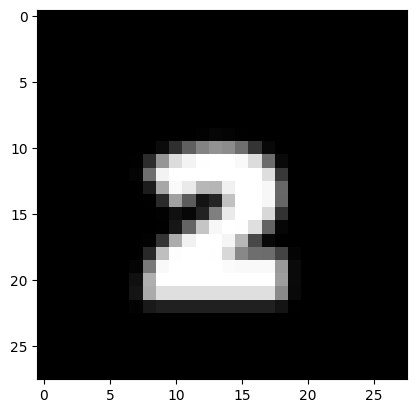

In [8]:
for X_batch, y_batch in val_dataloader:
    i = 10
    plt.imshow(X_batch[i][0], cmap='gray')
    print(y_batch[i])
    break

# CNN Classifier Model

In [9]:
class HandwrittenDetectionModel2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1), torch.nn.BatchNorm2d(32), torch.nn.ReLU(), torch.nn.Dropout(0.5))
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1), torch.nn.BatchNorm2d(64), torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=2, stride=2), torch.nn.Dropout(0.5))
        self.linear = torch.nn.Sequential(torch.nn.Linear(64 * 14 * 14, 32), torch.nn.BatchNorm1d(32), torch.nn.ReLU(), torch.nn.Dropout(0.5), torch.nn.Linear(32, 1), torch.nn.Sigmoid())
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        out = self.linear(x.reshape(x.shape[0], -1))
        return out

model = HandwrittenDetectionModel2()
model

HandwrittenDetectionModel2(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=12544, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

tensor(1., dtype=torch.float64)


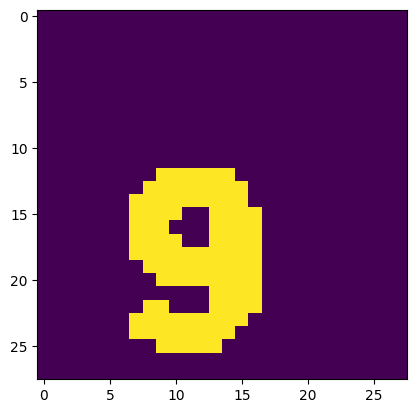

In [10]:
#testfunction
for X_batch, y_batch in test_dataloader:
    np_batch = X_batch.numpy()
    for i in range(len(np_batch)):
        np_batch[i][0] = cv2.threshold((np_batch[i][0] * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    thresh = torch.from_numpy(np_batch)
    plt.imshow(thresh[10][0])
    print(y_batch[10])
    break

In [11]:
thresh.shape

torch.Size([256, 1, 28, 28])

# Load Model

In [12]:
model = torch.load('models/model_dig_hw')

In [13]:
model

HandwrittenDetectionModel2(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=12544, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [14]:
def image_thresh(X_batch):
    np_batch = X_batch.numpy()
    for i in range(len(np_batch)):
        np_batch[i][0] = cv2.threshold((np_batch[i][0] * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return torch.from_numpy(np_batch / 255).float()

### Training

In [ ]:
import torch
import tqdm
import torch.nn as nn
import torch.optim as optim
 
num_epochs = 1

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for X, y in tqdm.tqdm(train_dataloader):
        X = image_thresh(X)
        outputs = model(X)

        y = y.reshape(-1).float()
        outputs = outputs.reshape(-1)
        loss = criterion(outputs, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total += y.size(0)
        correct += (outputs.round() == y).sum()

    train_loss /= len(train_dataloader)
    train_acc = 100 * correct / total

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in val_dataloader:
            X = image_thresh(X)
            outputs = model(X)
        
            y = y.reshape(-1).float()
            outputs = outputs.reshape(-1)
            loss = criterion(outputs, y)

            val_loss += loss.item()
            total += y.size(0)
            correct += (outputs.round() == y).sum()
 
        val_loss /= len(val_dataloader)
        val_acc = 100 * correct / total

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'
            .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

## Evaluation on Testset

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for X, y in test_dataloader:
        X = image_thresh(X)
        outputs = model(X)
        
        y = y.reshape(-1).float()
        outputs = outputs.reshape(-1)
        loss = criterion(outputs, y)

        test_loss += loss.item()
        total += y.size(0)

        correct += (outputs.round() == y).sum()

    test_loss /= len(test_dataloader)
    test_acc = 100 * correct / total

print('Test Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'
        .format(test_acc, test_loss, test_acc))

Test Acc: 99.41%, Test Loss: 0.0157, Test Acc: 99.41%


In [ ]:
#torch.save(model, 'models/model_dig_hw_2')